In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Instructions:
Download the data from this [link](https://colab.research.google.com/drive/16Q3M_H6L1l_y2xu2MQP6icj6iN75zu18?usp=sharing). Unzip and upload it to your google drive in a folder called ```Homework2```. Make sure all files are stored in a folder called ```data``` inside the folder ```Homework2```. Copy the path after ```gdrive/``` to folder ```Homework2``` and paste it in the space above.

## Q1a. Getting a point cloud from a Depth image

You are given a rgb image, a depth image and a mask. Your task is to generate point cloud data from the given depth image and the corresponding colour from the RGB image. Recall we used projection equations to project 3D points to a 2D plane. Here, given depth, we need to reproject the points back onto a 3D plane. You are also given the camera data (focal length and camera center). Use the data from file ```generate_point_cloud.npz```

```CORRECTION: The pricipal points are not given in the file. Here are the values for the principal point: 0.4224, -0.0300```

![](https://drive.google.com/uc?export=view&id=1Dng54OFGump4H5-m7BLpgoL3ikMLa7aP)


In [25]:
def generate_point_clouds(rgb_image, depth_image, mask, camera_data):
    """
    Generate a 3D point cloud from a given RGB image, depth image, and mask using camera data.

    Args:
        rgb_image (numpy.ndarray): RGB image as a NumPy array.
        depth_image (numpy.ndarray): Depth image as a NumPy array.
        mask (numpy.ndarray): Binary mask indicating valid pixels in the images.
        camera_data (dict): Camera parameters including focal length and camera center.

    Returns:
        point_cloud (numpy.ndarray): 3D point cloud represented as a NumPy array of shape (N, 3),
            where N is the number of valid points.
        rgb (numpy.ndarray): RGB color values corresponding to the 3D points, represented as a
            NumPy array of shape (N, 3), where N is the number of valid points.
    """
    # load camera parameters
    focal_length = camera_data['focal_length']
    f_x = focal_length[:, 0]
    f_y = focal_length[:, 1]
    
    # The pricipal point
    x_c, y_c = 0.4224, -0.0300
    
    width, height = rgb_image.shape[1], rgb_image.shape[0]
    
    point_cloud = []
    colors = []
    # Gather corresponding depths
    for v in range(height): 
            for u in range(width):  
                if mask[v, u] > 0:
                    z = depth_image[v, u]
                    if z == 0:
                        continue  # skip invalid depths
                    x = (u - x_c) * z / f_x
                    y = (v - y_c) * z / f_y
                    point_cloud.append([x, y, z])
                    colors.append(rgb_image[v, u])
    return point_cloud, colors

## Q1b. Generate Visualization

Use the point clouds and rgb data obtained from Q1a and plot them to generate at least 3 different views of the object

```Note: You will need to visualize a lot of point clouds in this assignment. It would help if you generalize this function for future tasks. Feel free to modify input args as needed.```

In [26]:
def visualizing_point_clouds(point_cloud,rgb):
    point_cloud = np.array(point_cloud)
    point_cloud = np.squeeze(point_cloud, axis=-1) 

    colors = np.array(rgb)

    if colors.max() > 1.0:
        colors = colors / 255.0  

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0],
               point_cloud[:, 1],
               point_cloud[:, 2],
               c=colors, s=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Point Cloud Visualization')
    ax.view_init(elev=30, azim=45) 

    plt.tight_layout()
    plt.show()

    

Write a main function to load data and use the functions you defined above to produce the required output:

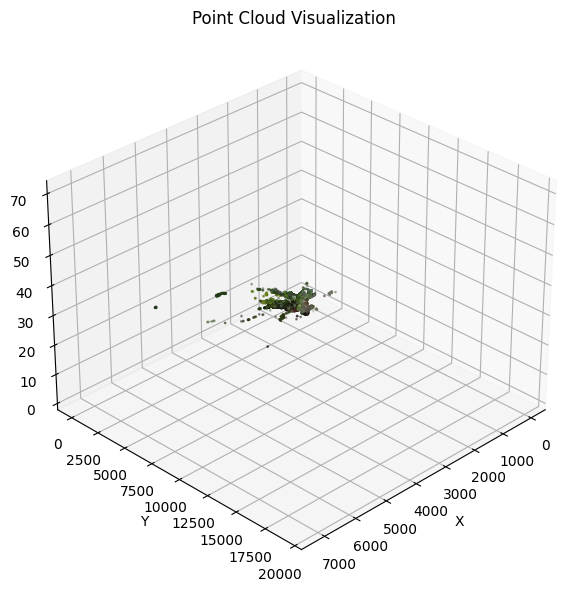

In [27]:

path = './data/generate_point_cloud.npz'

data = np.load(path)

# load images
rgb = data['rgb']
mask = data['mask']
depth = data['depth']
depth = depth.reshape(depth.shape[0], depth.shape[1], 1)

pcds, colors = generate_point_clouds(rgb, depth, mask, data)
visualizing_point_clouds(pcds, colors)

# Iterative Closest Point Algorithm

When working with real world point cloud data, one often encounters 2 sets points that are unaligned but represent the same scene or object. These point clouds might be slightly rotated, translated, or even have non-uniform scaling due to various factors such as sensor noise, calibration errors, or deformations in the object itself. In such cases, accurately aligning these point clouds becomes essential to make meaningful comparisons or perform further analysis. The Iterative Closest Point (ICP) algorithm is a powerful tool that addresses this challenge, providing a systematic and efficient way to find the optimal transformation that aligns two point clouds or shapes.

In this section, we are going to develop an in-depth understanding of the ICP algorithm by implementing it and computing a rigid transformation between two point clouds.

Pseudo Code:

![](https://drive.google.com/uc?export=view&id=1XfswHyZWBLb06chYDQRc6Ze6Oiwkxmpd)






## Q2a. Estimate Correspondences between the two point clouds.
You are given two point clouds X and Y, an initial guess of transformation T and rotation R and a threshold for maximum distance between two points.
Return a list of estimated point correspondences. Procedure to follow is given in the pseudocode.

In [28]:
def estimate_correspondences(X, Y, t, R, dis_threshold):
    """
    Estimate Correspondences between two point clouds.

    This function takes two point clouds, X and Y, along with an initial guess of
    translation 't' and rotation 'R', and a threshold value for the maximum distance
    between two points to consider them as correspondences.

    Parameters:
    X (numpy.ndarray): The first point cloud represented as an N x 3 numpy array,
                       where N is the number of points.
    Y (numpy.ndarray): The second point cloud represented as an M x 3 numpy array,
                       where M is the number of points.
    t (numpy.ndarray): The initial guess for translation, a 1 x 3 numpy array.
    R (numpy.ndarray): The initial guess for rotation, a 3 x 3 numpy array.
    dis_threshold (float): The maximum distance between two points to consider them as
                       correspondences.

    Returns:
    correspondences (numpy.ndarray): A numpy array of estimated point correspondences, where each
                            correspondence is [x, y], where 'x' is the index of point
                            from point cloud X, and 'y' is is the index of a point from point cloud Y.
    """

    correspondences = []
    
    for i, xi in enumerate(X):
        xi_trans = R @ xi + t
        dists = np.linalg.norm(Y - xi_trans, axis=1)
        # find the closest point in Y to xi_trans
        j = np.argmin(dists)
        if dists[j] < dis_threshold:
            correspondences.append((i, j))

    return correspondences

## Q2b. Estimating Optimal Rigid Transform

Now that we have computed the correspondences, it is time to compute the transform between them. The algorithm to accomplish this task is mentioned below:
![](https://drive.google.com/uc?export=view&id=14JANZvk4sO4CWNqQNhKJx6PT7l7hpKM3)



In [29]:
def compute_rigid_transformation(X,Y,correspondences):
    """
    Estimate the optimal rigid transformation between two point clouds.

    Given two point clouds X and Y, along with a list of estimated point correspondences,
    this function calculates the optimal rotation and translation that best aligns
    point cloud X with point cloud Y.

    Parameters:
    X (numpy.ndarray): The first point cloud represented as an N x 3 numpy array,
                       where N is the number of points.
    Y (numpy.ndarray): The second point cloud represented as an M x 3 numpy array,
                       where M is the number of points.
    correspondences (numpy.ndarray): A numpy array of estimated point correspondences, where each
                            correspondence is [x, y], where 'x' is the index of point
                            from point cloud X, and 'y' is is the index of a point from point cloud Y.

    Returns:
    rotation (numpy.ndarray): The estimated rotation matrix (3x3) that best aligns
                             point cloud X with point cloud Y.
    translation (numpy.ndarray): The estimated translation vector (1x3) that best
                                aligns point cloud X with point cloud Y.
    """
    X_corr = np.array([X[i] for i, j in correspondences])
    Y_corr = np.array([Y[j] for i, j in correspondences])

    X_mean = X_corr.mean(axis=0)
    Y_mean = Y_corr.mean(axis=0)
    X_centered = X_corr - X_mean
    Y_centered = Y_corr - Y_mean

    H = X_centered.T @ Y_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = Y_mean - R @ X_mean
    return R, t

## Q2c. Stitching Everything Together

i. Use the functions you defined in the previous questions and implement the ICP algorithm.

ii. Test the algorithm by using the point clouds in the files ```data/point_cloud_X.txt``` and ```data/point_cloud_Y.txt```. Set initial estimate of ```t``` as 0, ```R``` as identity, ```dmax``` as 0.25 and run the code for 30 iterations

iii. Report the RMSE error computed from the following equation:

![](https://drive.google.com/uc?export=view&id=1cVLvZwm9T1Rj9CKHzQYdZDaokoWqup0O)









In [ ]:
def ICP_algorithm(X, Y, t_init, R_init, threshold=1e-6, max_iter=30, dis_threshold=0.25):
    
    t_hat = t_init.copy()
    R_hat = R_init.copy()

    for iter in range(max_iter):
        print(f"Iteration {iter+1}")
        correspondences = estimate_correspondences(X, Y, t_hat, R_hat, dis_threshold)

        if len(correspondences) < 3:
            print("Too few correspondences. Consider increasing dis_threshold.")
            break

        R_new, t_new = compute_rigid_transformation(X, Y, correspondences)

        if np.linalg.norm(t_hat - t_new) < threshold and np.linalg.norm(R_hat - R_new) < threshold:
            print("Converged.")
            break

        t_hat = t_new
        R_hat = R_new

    return t_hat, R_hat, correspondences



def RMSE_error(X, Y,t,R):
    X_aligned = (R @ X.T).T + t
    rmse = np.sqrt(np.mean(np.sum((X_aligned - Y)**2, axis=1)))
    return rmse


#---- Write your 'main' function to load data and use the ICP algorithm -------#


pcd1 = np.loadtxt('./data/point_cloud_X.txt')
pcd2 = np.loadtxt('./data/point_cloud_Y.txt')


# Initialize the transformation and rotation
t_init = np.zeros(3)
R_init = np.eye(3)
threshold = 1e-6

t_hat, R_hat, correspondences = ICP_algorithm(pcd1, pcd2, t_init, R_init, dis_threshold=0.25)
pcd1_aligned = (R_hat @ pcd1.T).T + t_hat
rmse = RMSE_error(pcd1, pcd2, t_hat, R_hat)
print(f"RMSE Error: {rmse:.6f}")

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
RMSE Error: 0.460434


## Q2d. Visualizing the point clouds
Write a function to visualize the two point clouds before and after transformation to witness the might of the ICP algorithm. You are free to use the function you wrote previously for Q1

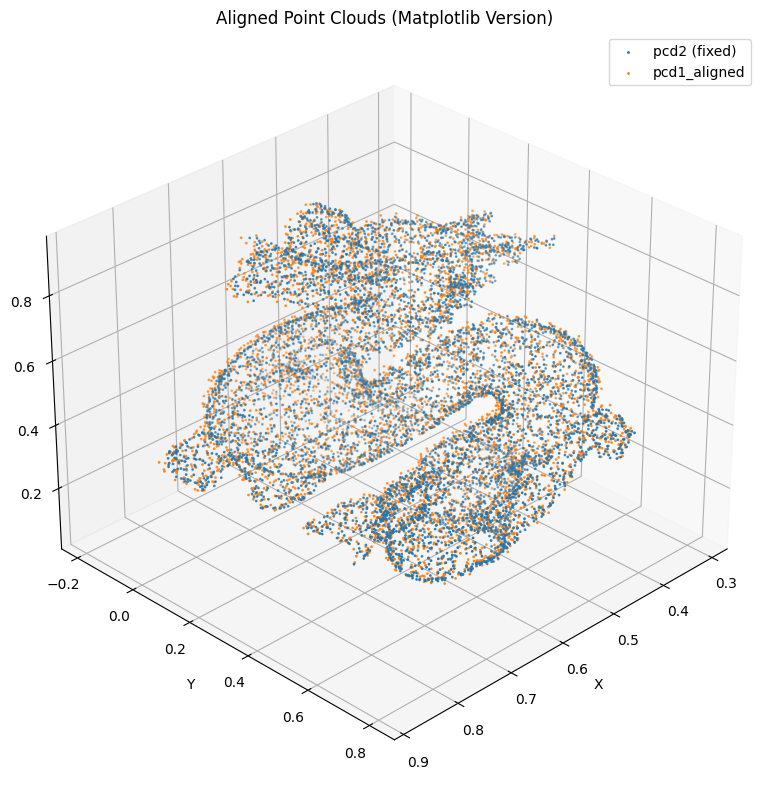

In [31]:
pcd1  = np.array(pcd1_aligned).reshape(-1, 3)
pcd2 = np.array(pcd2).reshape(-1, 3)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制两个点云
ax.scatter(pcd1[:, 0], pcd1[:, 1], pcd1[:, 2], s=1, label='pcd2 (fixed)')
ax.scatter(pcd2[:, 0], pcd2[:, 1], pcd2[:, 2], s=1, label='pcd1_aligned')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Aligned Point Clouds (Matplotlib Version)')
ax.legend(loc='upper right')

ax.view_init(elev=30, azim=45)  # 自定义视角
plt.tight_layout()
plt.show()


# Pointnets

PointNet is a groundbreaking neural network architecture tailored for the classification and segmentation of point cloud data. Introduced in the seminal paper "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" by Charles R. Qi, Hao Su, Kaichun Mo, and Leonidas J. Guibas, PointNet represents a significant advancement in the field of 3D deep learning.

Processing point clouds poses unique challenges compared to traditional 2D image data. Point clouds are unordered, meaning that the order of the points within the cloud does not inherently convey information. Furthermore, point clouds may have varying numbers of points, making it challenging to apply standard convolutional neural networks (CNNs) designed for regular grids.


In the next few sections, we are going to implement the classification and segmentation network.

## Dataloader

In [4]:
class cocoDataset(Dataset):
    def __init__(self, path, train=True):
        self.path = path
        if train:
            self.data_path = self.path + "/train_data.npy"
            self.label_path = self.path + "/train_labels.npy"
        else:
            self.data_path = self.path + "/test_data.npy"
            self.label_path = self.path + "/test_labels.npy"
        self.data = torch.from_numpy(np.load(self.data_path))
        self.label = torch.from_numpy(np.load(self.label_path)).to(torch.long)

    def __len__(self):
        return self.data.size()[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

def get_data_loader(path, batch_size, train=True):
    """
    Creates training and test data loaders
    """
    dataset = cocoDataset(path, train)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=train, num_workers=1)


    return dataloader

# Q3. Classification

In this question, you are given point clouds of objects corresponding to 3 different classes: Vase, Chair and Lamp . You are to implement the pointnet neural network and train it to differentiate between different objects.

Note: Use of a GPU is recommended. You can switch to a GPU runtime by going to ```Runtime>Change Runtime Type```


## Q3a. Implementation of Pointnet Architecture.

Refer to the Diagram below to implement the structure of Pointnet for classification.

```Note1: The values in brackets correspond to layers. After every layer there is a 1D Batch normalization layer and a Relu activation layer. Refer to pytorch documentation on how to implement these layers.```

```Note2: Linear layers can also be implemented as 1D Convolutions with Kernel size 1```

```Note3: Remember to use a softmax layer to get the output scores```

![](https://drive.google.com/uc?export=view&id=19k9E94pHVrv8QyNoedNIUi2D-tnDi95t)

Source: [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://doi.org/10.48550/arXiv.1612.00593)

In [33]:
import torch.nn as nn
import torch
import torch.nn.functional as F


class PointNetClassification(nn.Module):
    def __init__(self, num_classes):
        super(PointNetClassification, self).__init__()

        self.mlp1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.mlp2 = nn.Sequential(
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, 3, N]
        x = self.mlp1(x)  # [B, 64, N]
        x = self.mlp2(x)  # [B, 1024, N]
        x = torch.max(x, 2)[0]  # [B, 1024]
        x = self.fc_layers(x)  # [B, num_classes]
        return x  # No softmax


## Q3b. Training the network

To train the network the following steps need to be followed:


i. Check and convert the dimensions into proper order. Recall, the model needs the data to be in ```B x C x N``` format where B is the batch, C is the channels and N is the number of points

ii. The dataset contains 10000 points per point clouds. To ease the computation, we are only using 1000 points per point cloud. Slice the data so that you are only using 1000 points.

iii. Compute Forward pass

iv. Calculate the Loss. We are using the CrossEntropyLoss for classification.

v. Perform back propogation and optimize

In [39]:
def train(train_dataloader, model, opt, epoch, device, task, num_seg_classes = 6):
    
    criterion = nn.CrossEntropyLoss()
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(train_dataloader):
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        opt.zero_grad()
        
        outputs = model(point_clouds)
        labels = labels
        
        # Initialize & Calculate Loss and perform back propogation
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    return epoch_loss

## Q3c. Testing the Network

i. Perform the same steps as Q3b to prepare the data for the network.

ii. Get the predictions from your network. Remember to not compute gradients or the loss!

iii. Calculate the accuracy of the model by comparing how many predictions correctly match the labels and dividing the number by total number of datapoints








In [40]:
def test(test_dataloader, model, epoch, device, task):

    model.eval()

    # Evaluation in Classification Task
    correct_obj = 0
    num_obj = 0
    with torch.no_grad():
        for batch in test_dataloader:
            point_clouds, labels = batch
            point_clouds = point_clouds.to(device)
            labels = labels.to(device).to(torch.long)
            outputs = model(point_clouds)  # [B, 6]
            predicted = torch.argmax(outputs, dim=1)  # [B]

            correct_obj += (predicted == labels).sum().item()
            num_obj += labels.size(0)


    # Compute Accuracy of Test Dataset
    accuracy = correct_obj / num_obj

    return accuracy

## Running the Model

In [42]:
NUM_CLASSES = 3
learning_rate = 0.001
path = "./data/cls"
batch_size = 32
num_epochs = 150
model_save_path = os.path.join(os. getcwd(), 'model/best_model.pt')
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = PointNetClassification(NUM_CLASSES).to(device)
opt = optim.Adam(model.parameters(), learning_rate, betas=(0.9, 0.999))
train_dataloader = get_data_loader(path,batch_size, True)
test_dataloader = get_data_loader(path,batch_size, False)
print("++++++ SUCCESSFULLY LOADED DATA ++++++")

best_accuracy = -1

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = train(train_dataloader, model, opt, epoch, device, "cls")

    test_accuracy = test(test_dataloader, model, epoch, device, "cls")
    print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))

    if (test_accuracy > best_accuracy):
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), model_save_path)

print("===============TRAINING COMPLETE===============")

++++++ SUCCESSFULLY LOADED DATA ++++++


  1%|          | 1/150 [00:14<35:26, 14.27s/it]

epoch: 0   train loss: 39.0780   test accuracy: 0.9150


  1%|▏         | 2/150 [00:28<35:17, 14.31s/it]

epoch: 1   train loss: 29.5758   test accuracy: 0.9286


  2%|▏         | 3/150 [00:42<35:03, 14.31s/it]

epoch: 2   train loss: 25.6337   test accuracy: 0.9182


  3%|▎         | 4/150 [00:57<34:52, 14.33s/it]

epoch: 3   train loss: 23.8727   test accuracy: 0.9150


  3%|▎         | 5/150 [01:11<34:38, 14.33s/it]

epoch: 4   train loss: 22.6205   test accuracy: 0.9381


  4%|▍         | 6/150 [01:25<34:19, 14.31s/it]

epoch: 5   train loss: 21.9477   test accuracy: 0.9496


  5%|▍         | 7/150 [01:40<34:09, 14.33s/it]

epoch: 6   train loss: 18.9475   test accuracy: 0.9517


  5%|▌         | 8/150 [01:54<33:56, 14.34s/it]

epoch: 7   train loss: 19.0471   test accuracy: 0.9570


  6%|▌         | 9/150 [02:08<33:36, 14.30s/it]

epoch: 8   train loss: 17.5756   test accuracy: 0.9496


  7%|▋         | 10/150 [02:23<33:21, 14.29s/it]

epoch: 9   train loss: 17.0501   test accuracy: 0.9517


  7%|▋         | 11/150 [02:37<33:05, 14.28s/it]

epoch: 10   train loss: 15.8540   test accuracy: 0.9528


  8%|▊         | 12/150 [02:51<32:46, 14.25s/it]

epoch: 11   train loss: 15.7129   test accuracy: 0.9402


  9%|▊         | 13/150 [03:05<32:33, 14.26s/it]

epoch: 12   train loss: 14.7947   test accuracy: 0.9591


  9%|▉         | 14/150 [03:20<32:16, 14.24s/it]

epoch: 13   train loss: 12.6019   test accuracy: 0.9570


 10%|█         | 15/150 [03:34<32:01, 14.23s/it]

epoch: 14   train loss: 14.9134   test accuracy: 0.9601


 11%|█         | 16/150 [03:48<31:44, 14.22s/it]

epoch: 15   train loss: 13.8728   test accuracy: 0.9444


 11%|█▏        | 17/150 [04:02<31:29, 14.21s/it]

epoch: 16   train loss: 12.8797   test accuracy: 0.9622


 12%|█▏        | 18/150 [04:16<31:16, 14.21s/it]

epoch: 17   train loss: 12.9888   test accuracy: 0.9486


 13%|█▎        | 19/150 [04:31<31:02, 14.22s/it]

epoch: 18   train loss: 13.0489   test accuracy: 0.9664


 13%|█▎        | 20/150 [04:45<30:45, 14.19s/it]

epoch: 19   train loss: 11.9184   test accuracy: 0.9643


 14%|█▍        | 21/150 [04:59<30:34, 14.22s/it]

epoch: 20   train loss: 12.3594   test accuracy: 0.9507


 15%|█▍        | 22/150 [05:13<30:22, 14.24s/it]

epoch: 21   train loss: 10.8220   test accuracy: 0.9664


 15%|█▌        | 23/150 [05:28<30:12, 14.27s/it]

epoch: 22   train loss: 10.3975   test accuracy: 0.9549


 16%|█▌        | 24/150 [05:42<29:56, 14.26s/it]

epoch: 23   train loss: 10.6313   test accuracy: 0.9475


 17%|█▋        | 25/150 [05:56<29:40, 14.25s/it]

epoch: 24   train loss: 9.8627   test accuracy: 0.9675


 17%|█▋        | 26/150 [06:10<29:26, 14.25s/it]

epoch: 25   train loss: 9.0502   test accuracy: 0.9633


 18%|█▊        | 27/150 [06:24<29:08, 14.22s/it]

epoch: 26   train loss: 9.3558   test accuracy: 0.9580


 19%|█▊        | 28/150 [06:39<28:52, 14.20s/it]

epoch: 27   train loss: 9.2131   test accuracy: 0.9601


 19%|█▉        | 29/150 [06:53<28:37, 14.19s/it]

epoch: 28   train loss: 8.6710   test accuracy: 0.9391


 20%|██        | 30/150 [07:07<28:23, 14.20s/it]

epoch: 29   train loss: 7.5416   test accuracy: 0.9685


 21%|██        | 31/150 [07:21<28:16, 14.26s/it]

epoch: 30   train loss: 8.5273   test accuracy: 0.9675


 21%|██▏       | 32/150 [07:36<28:03, 14.27s/it]

epoch: 31   train loss: 8.8293   test accuracy: 0.9591


 22%|██▏       | 33/150 [07:50<27:44, 14.22s/it]

epoch: 32   train loss: 8.5930   test accuracy: 0.9685


 23%|██▎       | 34/150 [08:04<27:31, 14.24s/it]

epoch: 33   train loss: 7.2002   test accuracy: 0.9643


 23%|██▎       | 35/150 [08:18<27:17, 14.24s/it]

epoch: 34   train loss: 7.8990   test accuracy: 0.9664


 24%|██▍       | 36/150 [08:33<27:02, 14.24s/it]

epoch: 35   train loss: 7.4929   test accuracy: 0.9412


 25%|██▍       | 37/150 [08:47<26:47, 14.23s/it]

epoch: 36   train loss: 7.1787   test accuracy: 0.9622


 25%|██▌       | 38/150 [09:01<26:32, 14.22s/it]

epoch: 37   train loss: 7.3872   test accuracy: 0.9654


 26%|██▌       | 39/150 [09:15<26:19, 14.23s/it]

epoch: 38   train loss: 6.2311   test accuracy: 0.9654


 27%|██▋       | 40/150 [09:30<26:08, 14.26s/it]

epoch: 39   train loss: 6.5334   test accuracy: 0.9696


 27%|██▋       | 41/150 [09:44<25:54, 14.26s/it]

epoch: 40   train loss: 5.7970   test accuracy: 0.9559


 28%|██▊       | 42/150 [09:58<25:41, 14.27s/it]

epoch: 41   train loss: 6.3033   test accuracy: 0.9654


 29%|██▊       | 43/150 [10:13<25:34, 14.34s/it]

epoch: 42   train loss: 5.7887   test accuracy: 0.9685


 29%|██▉       | 44/150 [10:27<25:17, 14.32s/it]

epoch: 43   train loss: 6.0915   test accuracy: 0.9633


 30%|███       | 45/150 [10:41<25:00, 14.29s/it]

epoch: 44   train loss: 5.4954   test accuracy: 0.9580


 31%|███       | 46/150 [10:55<24:48, 14.32s/it]

epoch: 45   train loss: 5.6043   test accuracy: 0.9140


 31%|███▏      | 47/150 [11:10<24:32, 14.29s/it]

epoch: 46   train loss: 6.1614   test accuracy: 0.9580


 32%|███▏      | 48/150 [11:24<24:16, 14.28s/it]

epoch: 47   train loss: 9.4452   test accuracy: 0.9654


 33%|███▎      | 49/150 [11:38<23:57, 14.24s/it]

epoch: 48   train loss: 5.7444   test accuracy: 0.9675


 33%|███▎      | 50/150 [11:52<23:44, 14.25s/it]

epoch: 49   train loss: 6.6276   test accuracy: 0.9654


 34%|███▍      | 51/150 [12:07<23:32, 14.26s/it]

epoch: 50   train loss: 4.7563   test accuracy: 0.9633


 35%|███▍      | 52/150 [12:21<23:20, 14.29s/it]

epoch: 51   train loss: 5.3150   test accuracy: 0.9633


 35%|███▌      | 53/150 [12:35<23:04, 14.27s/it]

epoch: 52   train loss: 5.7085   test accuracy: 0.9696


 36%|███▌      | 54/150 [12:50<22:49, 14.27s/it]

epoch: 53   train loss: 4.5318   test accuracy: 0.9643


 37%|███▋      | 55/150 [13:04<22:35, 14.27s/it]

epoch: 54   train loss: 4.5692   test accuracy: 0.9633


 37%|███▋      | 56/150 [13:18<22:22, 14.28s/it]

epoch: 55   train loss: 5.5729   test accuracy: 0.9591


 38%|███▊      | 57/150 [13:32<22:05, 14.25s/it]

epoch: 56   train loss: 4.0485   test accuracy: 0.9727


 39%|███▊      | 58/150 [13:47<21:55, 14.30s/it]

epoch: 57   train loss: 4.7615   test accuracy: 0.9696


 39%|███▉      | 59/150 [14:01<21:40, 14.30s/it]

epoch: 58   train loss: 4.3444   test accuracy: 0.9654


 40%|████      | 60/150 [14:15<21:25, 14.28s/it]

epoch: 59   train loss: 3.5621   test accuracy: 0.9717


 41%|████      | 61/150 [14:29<21:08, 14.25s/it]

epoch: 60   train loss: 3.9246   test accuracy: 0.9727


 41%|████▏     | 62/150 [14:44<20:53, 14.24s/it]

epoch: 61   train loss: 6.2477   test accuracy: 0.9633


 42%|████▏     | 63/150 [14:58<20:42, 14.28s/it]

epoch: 62   train loss: 4.2292   test accuracy: 0.9696


 43%|████▎     | 64/150 [15:12<20:27, 14.27s/it]

epoch: 63   train loss: 2.6332   test accuracy: 0.9706


 43%|████▎     | 65/150 [15:26<20:12, 14.26s/it]

epoch: 64   train loss: 3.6984   test accuracy: 0.9633


 44%|████▍     | 66/150 [15:41<19:58, 14.27s/it]

epoch: 65   train loss: 3.7225   test accuracy: 0.9664


 45%|████▍     | 67/150 [15:55<19:42, 14.25s/it]

epoch: 66   train loss: 2.6520   test accuracy: 0.9696


 45%|████▌     | 68/150 [16:09<19:29, 14.26s/it]

epoch: 67   train loss: 4.2934   test accuracy: 0.9685


 46%|████▌     | 69/150 [16:23<19:13, 14.24s/it]

epoch: 68   train loss: 3.3494   test accuracy: 0.9717


 47%|████▋     | 70/150 [16:38<18:59, 14.24s/it]

epoch: 69   train loss: 2.5741   test accuracy: 0.9696


 47%|████▋     | 71/150 [16:52<18:46, 14.25s/it]

epoch: 70   train loss: 5.2486   test accuracy: 0.9580


 48%|████▊     | 72/150 [17:06<18:31, 14.25s/it]

epoch: 71   train loss: 3.9856   test accuracy: 0.9706


 49%|████▊     | 73/150 [17:20<18:15, 14.23s/it]

epoch: 72   train loss: 2.5375   test accuracy: 0.9643


 49%|████▉     | 74/150 [17:35<18:00, 14.22s/it]

epoch: 73   train loss: 3.5041   test accuracy: 0.9654


 50%|█████     | 75/150 [17:49<17:46, 14.22s/it]

epoch: 74   train loss: 4.2829   test accuracy: 0.9643


 51%|█████     | 76/150 [18:03<17:31, 14.21s/it]

epoch: 75   train loss: 2.1360   test accuracy: 0.9591


 51%|█████▏    | 77/150 [18:17<17:19, 14.24s/it]

epoch: 76   train loss: 3.0061   test accuracy: 0.9706


 52%|█████▏    | 78/150 [18:32<17:08, 14.28s/it]

epoch: 77   train loss: 5.1381   test accuracy: 0.9601


 53%|█████▎    | 79/150 [18:46<16:53, 14.28s/it]

epoch: 78   train loss: 4.1783   test accuracy: 0.9727


 53%|█████▎    | 80/150 [19:00<16:36, 14.24s/it]

epoch: 79   train loss: 2.3802   test accuracy: 0.9622


 54%|█████▍    | 81/150 [19:15<16:26, 14.30s/it]

epoch: 80   train loss: 2.3814   test accuracy: 0.9717


 55%|█████▍    | 82/150 [19:29<16:12, 14.30s/it]

epoch: 81   train loss: 2.7912   test accuracy: 0.9517


 55%|█████▌    | 83/150 [19:43<16:00, 14.33s/it]

epoch: 82   train loss: 3.6393   test accuracy: 0.9717


 56%|█████▌    | 84/150 [19:58<15:45, 14.33s/it]

epoch: 83   train loss: 1.9764   test accuracy: 0.9685


 57%|█████▋    | 85/150 [20:12<15:30, 14.32s/it]

epoch: 84   train loss: 1.7812   test accuracy: 0.9654


 57%|█████▋    | 86/150 [20:26<15:16, 14.32s/it]

epoch: 85   train loss: 2.7001   test accuracy: 0.9528


 58%|█████▊    | 87/150 [20:40<14:59, 14.28s/it]

epoch: 86   train loss: 5.3871   test accuracy: 0.9454


 59%|█████▊    | 88/150 [20:55<14:44, 14.26s/it]

epoch: 87   train loss: 1.7664   test accuracy: 0.9622


 59%|█████▉    | 89/150 [21:09<14:32, 14.30s/it]

epoch: 88   train loss: 3.1385   test accuracy: 0.9706


 60%|██████    | 90/150 [21:23<14:18, 14.32s/it]

epoch: 89   train loss: 1.1229   test accuracy: 0.9685


 61%|██████    | 91/150 [21:38<14:03, 14.30s/it]

epoch: 90   train loss: 3.8403   test accuracy: 0.9612


 61%|██████▏   | 92/150 [21:52<13:50, 14.31s/it]

epoch: 91   train loss: 2.9643   test accuracy: 0.9759


 62%|██████▏   | 93/150 [22:06<13:39, 14.37s/it]

epoch: 92   train loss: 1.1795   test accuracy: 0.9706


 63%|██████▎   | 94/150 [22:21<13:23, 14.34s/it]

epoch: 93   train loss: 1.7674   test accuracy: 0.9664


 63%|██████▎   | 95/150 [22:35<13:08, 14.33s/it]

epoch: 94   train loss: 2.9748   test accuracy: 0.9580


 64%|██████▍   | 96/150 [22:49<12:54, 14.34s/it]

epoch: 95   train loss: 2.7273   test accuracy: 0.9685


 65%|██████▍   | 97/150 [23:04<12:38, 14.31s/it]

epoch: 96   train loss: 1.6976   test accuracy: 0.9654


 65%|██████▌   | 98/150 [23:18<12:23, 14.29s/it]

epoch: 97   train loss: 1.2282   test accuracy: 0.9706


 66%|██████▌   | 99/150 [23:32<12:08, 14.28s/it]

epoch: 98   train loss: 2.5373   test accuracy: 0.9738


 67%|██████▋   | 100/150 [23:47<11:55, 14.31s/it]

epoch: 99   train loss: 3.1661   test accuracy: 0.9696


 67%|██████▋   | 101/150 [24:01<11:40, 14.30s/it]

epoch: 100   train loss: 3.2453   test accuracy: 0.9664


 68%|██████▊   | 102/150 [24:15<11:24, 14.27s/it]

epoch: 101   train loss: 2.5101   test accuracy: 0.9591


 69%|██████▊   | 103/150 [24:29<11:10, 14.26s/it]

epoch: 102   train loss: 3.6090   test accuracy: 0.9685


 69%|██████▉   | 104/150 [24:44<10:56, 14.27s/it]

epoch: 103   train loss: 1.2971   test accuracy: 0.9633


 70%|███████   | 105/150 [24:58<10:43, 14.30s/it]

epoch: 104   train loss: 1.1991   test accuracy: 0.9706


 71%|███████   | 106/150 [25:12<10:30, 14.34s/it]

epoch: 105   train loss: 1.7088   test accuracy: 0.9643


 71%|███████▏  | 107/150 [25:27<10:14, 14.30s/it]

epoch: 106   train loss: 2.2009   test accuracy: 0.9612


 72%|███████▏  | 108/150 [25:41<10:00, 14.30s/it]

epoch: 107   train loss: 1.5487   test accuracy: 0.9664


 73%|███████▎  | 109/150 [25:55<09:46, 14.31s/it]

epoch: 108   train loss: 1.2747   test accuracy: 0.9675


 73%|███████▎  | 110/150 [26:09<09:31, 14.30s/it]

epoch: 109   train loss: 2.2224   test accuracy: 0.9717


 74%|███████▍  | 111/150 [26:24<09:16, 14.27s/it]

epoch: 110   train loss: 1.2958   test accuracy: 0.9654


 75%|███████▍  | 112/150 [26:38<09:02, 14.28s/it]

epoch: 111   train loss: 1.3435   test accuracy: 0.9717


 75%|███████▌  | 113/150 [26:52<08:48, 14.28s/it]

epoch: 112   train loss: 1.3136   test accuracy: 0.9675


 76%|███████▌  | 114/150 [27:06<08:32, 14.25s/it]

epoch: 113   train loss: 3.6191   test accuracy: 0.9685


 77%|███████▋  | 115/150 [27:21<08:19, 14.27s/it]

epoch: 114   train loss: 1.9981   test accuracy: 0.9675


 77%|███████▋  | 116/150 [27:35<08:05, 14.29s/it]

epoch: 115   train loss: 0.6463   test accuracy: 0.9685


 78%|███████▊  | 117/150 [27:49<07:51, 14.30s/it]

epoch: 116   train loss: 1.3768   test accuracy: 0.9622


 79%|███████▊  | 118/150 [28:03<07:36, 14.25s/it]

epoch: 117   train loss: 2.5291   test accuracy: 0.9591


 79%|███████▉  | 119/150 [28:18<07:21, 14.24s/it]

epoch: 118   train loss: 2.8160   test accuracy: 0.9685


 80%|████████  | 120/150 [28:32<07:06, 14.21s/it]

epoch: 119   train loss: 2.1086   test accuracy: 0.9727


 81%|████████  | 121/150 [28:46<06:53, 14.25s/it]

epoch: 120   train loss: 1.5549   test accuracy: 0.9664


 81%|████████▏ | 122/150 [29:00<06:39, 14.26s/it]

epoch: 121   train loss: 0.9952   test accuracy: 0.9717


 82%|████████▏ | 123/150 [29:15<06:24, 14.25s/it]

epoch: 122   train loss: 0.9532   test accuracy: 0.9664


 83%|████████▎ | 124/150 [29:29<06:10, 14.24s/it]

epoch: 123   train loss: 1.5393   test accuracy: 0.9664


 83%|████████▎ | 125/150 [29:43<05:55, 14.23s/it]

epoch: 124   train loss: 0.7584   test accuracy: 0.9664


 84%|████████▍ | 126/150 [29:57<05:42, 14.26s/it]

epoch: 125   train loss: 1.7296   test accuracy: 0.9696


 85%|████████▍ | 127/150 [30:12<05:26, 14.21s/it]

epoch: 126   train loss: 2.3743   test accuracy: 0.9528


 85%|████████▌ | 128/150 [30:26<05:12, 14.22s/it]

epoch: 127   train loss: 2.2396   test accuracy: 0.9643


 86%|████████▌ | 129/150 [30:40<04:58, 14.21s/it]

epoch: 128   train loss: 2.0794   test accuracy: 0.9633


 87%|████████▋ | 130/150 [30:54<04:44, 14.20s/it]

epoch: 129   train loss: 1.0985   test accuracy: 0.9706


 87%|████████▋ | 131/150 [31:08<04:29, 14.19s/it]

epoch: 130   train loss: 0.3987   test accuracy: 0.9654


 88%|████████▊ | 132/150 [31:23<04:15, 14.20s/it]

epoch: 131   train loss: 2.2767   test accuracy: 0.9486


 89%|████████▊ | 133/150 [31:37<04:02, 14.24s/it]

epoch: 132   train loss: 3.0077   test accuracy: 0.9717


 89%|████████▉ | 134/150 [31:51<03:47, 14.24s/it]

epoch: 133   train loss: 2.6786   test accuracy: 0.9633


 90%|█████████ | 135/150 [32:05<03:33, 14.26s/it]

epoch: 134   train loss: 0.9642   test accuracy: 0.9622


 91%|█████████ | 136/150 [32:20<03:19, 14.24s/it]

epoch: 135   train loss: 2.2076   test accuracy: 0.9559


 91%|█████████▏| 137/150 [32:34<03:05, 14.24s/it]

epoch: 136   train loss: 1.8000   test accuracy: 0.9696


 92%|█████████▏| 138/150 [32:48<02:50, 14.20s/it]

epoch: 137   train loss: 2.2004   test accuracy: 0.9685


 93%|█████████▎| 139/150 [33:02<02:36, 14.20s/it]

epoch: 138   train loss: 1.1044   test accuracy: 0.9685


 93%|█████████▎| 140/150 [33:17<02:22, 14.25s/it]

epoch: 139   train loss: 0.9397   test accuracy: 0.9664


 94%|█████████▍| 141/150 [33:31<02:08, 14.30s/it]

epoch: 140   train loss: 2.2521   test accuracy: 0.9727


 95%|█████████▍| 142/150 [33:45<01:54, 14.32s/it]

epoch: 141   train loss: 1.0684   test accuracy: 0.9706


 95%|█████████▌| 143/150 [34:00<01:40, 14.34s/it]

epoch: 142   train loss: 1.9765   test accuracy: 0.9706


 96%|█████████▌| 144/150 [34:14<01:25, 14.32s/it]

epoch: 143   train loss: 0.6295   test accuracy: 0.9696


 97%|█████████▋| 145/150 [34:28<01:11, 14.32s/it]

epoch: 144   train loss: 0.8394   test accuracy: 0.9580


 97%|█████████▋| 146/150 [34:43<00:57, 14.32s/it]

epoch: 145   train loss: 0.7643   test accuracy: 0.9643


 98%|█████████▊| 147/150 [34:57<00:42, 14.31s/it]

epoch: 146   train loss: 1.8629   test accuracy: 0.9612


 99%|█████████▊| 148/150 [35:11<00:28, 14.33s/it]

epoch: 147   train loss: 3.5215   test accuracy: 0.9643


 99%|█████████▉| 149/150 [35:26<00:14, 14.32s/it]

epoch: 148   train loss: 0.8321   test accuracy: 0.9738


100%|██████████| 150/150 [35:40<00:00, 14.27s/it]

epoch: 149   train loss: 1.0362   test accuracy: 0.9675
===============TRAINING COMPLETE===============


## Q3d. Inference

i. Visualize few point clouds that have been classified correctly

ii. Visualize few point clouds that have been classfied incorrectly

You can re-use functions defined previously

/tmp/ipykernel_537436/2301497084.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/best_model.pt', map_location=device))


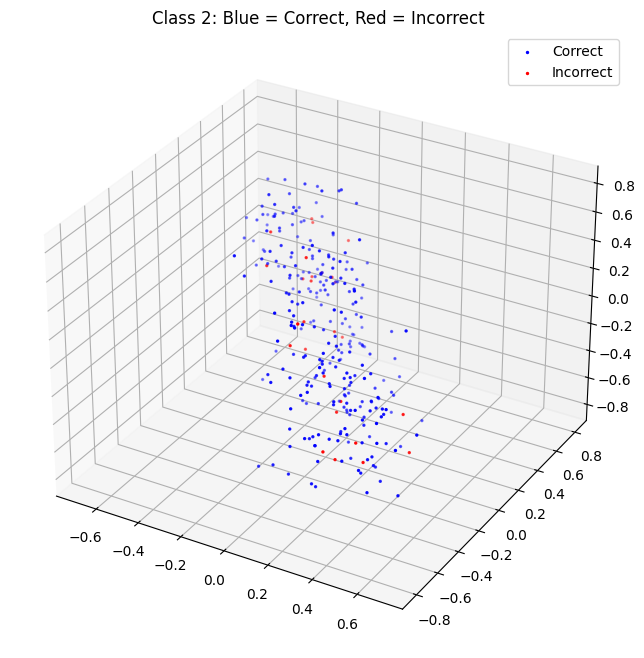

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_class_points(results, target_label, num_samples=1000):
    target_label -= 1 
    correct_points = []
    incorrect_points = []

    for r in results:
        if r['label'] == target_label:
            pc = r['point_cloud'].T  # shape: (N, 3)
            pc = pc - np.mean(pc, axis=0)  

            if r['label'] == r['predicted']:
                correct_points.append(pc)
            else:
                incorrect_points.append(pc)

            if len(correct_points) + len(incorrect_points) >= num_samples:
                break

    if not correct_points and not incorrect_points:
        print(f"No samples found for class {target_label}")
        return

    correct_all = np.vstack(correct_points) if correct_points else np.zeros((0, 3))
    incorrect_all = np.vstack(incorrect_points) if incorrect_points else np.zeros((0, 3))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    if correct_all.shape[0] > 0:
        ax.scatter(correct_all[:, 0], correct_all[:, 1], correct_all[:, 2], s=2, c='blue', label='Correct')
    if incorrect_all.shape[0] > 0:
        ax.scatter(incorrect_all[:, 0], incorrect_all[:, 1], incorrect_all[:, 2], s=2, c='red', label='Incorrect')

    ax.set_title(f'Class {target_label+1}: Blue = Correct, Red = Incorrect')
    ax.legend()
    plt.show()


def test_with_results(test_dataloader, model, device):
    model.eval()
    all_results = []

    with torch.no_grad():
        for point_clouds, labels in test_dataloader:
            point_clouds = point_clouds.to(device)
            labels = labels.to(device).long()
            outputs = model(point_clouds)
            predicted = torch.argmax(outputs, dim=1)

            for i in range(point_clouds.size(0)):
                all_results.append({
                    'point_cloud': point_clouds[i].cpu().numpy(),
                    'label': labels[i].item(),
                    'predicted': predicted[i].item()
                })

    return all_results

model = PointNetClassification(NUM_CLASSES).to(device)
model.load_state_dict(torch.load('./model/best_model.pt', map_location=device))
model.eval()

results = test_with_results(test_dataloader, model, device)

visualize_class_points(results, target_label=2, num_samples=5000)



# Q4. Segmentation

In this question, you are given a point cloud of different types of chairs with labels or classes for different parts of the chair: back rest, arm rest, seat etc. Your task is to create a PointNet segmentation network and train it to perform part segmentation.

Note: Use of a GPU is recommended. You can switch to a GPU runtime by going to ```Runtime>Change Runtime Type```

## Q4a. Implementation of the Pointnet architecture for segmentation

The architecture of pointnet for segmentation is given below:

![](https://drive.google.com/uc?export=view&id=1gATiXB-CD6LmetMjylBbg230CoowyVud)
Source: [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://doi.org/10.48550/arXiv.1612.00593)

There are a total of 6 classes that the points can be segmented into.

For segmentation, we store the local features extracted after the first set of MLP layers and concatenate each point in the local feature tensor with the global feature vector, making the input to the segmentation network ```n x (64+ 1024) =  nx1088```

```Note1: The values in brackets correspond to layers. After every layer there is a 1D Batch normalization layer and a Relu activation layer. Refer to pytorch documentation on how to implement these layers.```

```Note2: Your implementation should not contain the input transform and the feature transform```

```Note3: MLP can also be implemented as 1D Convolutions with Kernel size 1```






In [5]:
class SegmentationNetwork(nn.Module):
    def __init__(self, num_points = 2000, num_seg_classes = 6):
        super(SegmentationNetwork,self).__init__()
        self.mlp1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.mlp2 = nn.Sequential(
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        self.seg_mlp1 = nn.Sequential(
            nn.Conv1d(1088, 512, 1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.seg_mlp2 = nn.Sequential(
            nn.Conv1d(256, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, num_seg_classes, 1)
        )



    def forward(self, points):
        """
        Implement the forward pass
        Parameters:
        points (torch.Tensor): Tensor of shape (BxCxN) containing point cloud data
        where B is the batch size, C is number of channels, N is number of points in the point cloud

        Returns:
        output (torch.Tensor): Tensor of shape (B x num_seg_classes x N)
        """
        x = points.permute(0, 2, 1)  # -> [B, 3, N]

        local_features = self.mlp1(x)  # -> [B, 64, N]
        x = self.mlp2(local_features)  # -> [B, 1024, N]

        # max pool [B, 1024]
        global_feature = torch.max(x, dim=2, keepdim=True)[0]  # [B, 1024, 1]
        global_feature_expanded = global_feature.repeat(1, 1, local_features.size(2))  # [B, 1024, N]

        #  local + global => [B, 1088, N]
        seg_input = torch.cat([local_features, global_feature_expanded], dim=1)

        # 
        x = self.seg_mlp1(seg_input)  # -> [B, 256, N]
        x = self.seg_mlp2(x)  # -> [B, num_classes, N]
        output = x.permute(0, 2, 1)  # -> [B, N, num_classes]
        
        return output

## Q4b. Implementing the loss function

In this case, we need a special loss function because our data is not uniformly distributed. To illustrate it further run the following block:

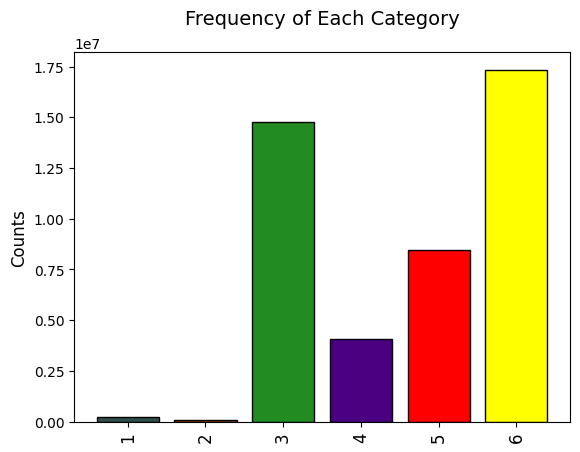

In [6]:
## RUN this block for the plot
CATEGORIES = {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
COLOR_MAP = {
    0  : (47, 79, 79),
    1  : (139, 69, 19),
    2  : (34, 139, 34),
    3  : (75, 0, 130),
    4  : (255, 0, 0),
    5  : (255, 255, 0)}
v_map_colors = np.vectorize(lambda x : COLOR_MAP[x])
NUM_CLASSES = len(CATEGORIES)
total_train_targets = []
train_dataloader = get_data_loader("data/seg",32, True)
for (_, targets) in train_dataloader:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)
class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins,
             color=[np.array(val)/255. for val in list(COLOR_MAP.values())],
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Frequency of Each Category', size=14, pad=20);

We observe a significant imbalance in the dataset. Penalizing the network equally for misclassifying categories of varying frequencies wouldn't be logical. If we penalize high-frequency categories the same as low-frequency ones, the model might excel at capturing common patterns but struggle with rare features.

For this reason, we define a few weights for the loss function that correspond to the different classes. These are learnable parameters and we are initializing them manually as per the visualization. You are free to experiment with them as you please.

In [7]:
alpha = np.ones(6)
alpha[5] *= 0.25
alpha[2] *= 0.35
alpha[4] *= 0.45
alpha[3] *= 0.5

Initialize the cross entropy loss with the weights and perform the forward pass. Refer to the pytorch documentation on Cross Entropy loss for  more information.

In [8]:
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha):
        super(PointNetSegLoss, self).__init__()
        # self.alpha = alpha
        self.register_buffer('alpha', torch.tensor(alpha, dtype=torch.float32))
        self.loss_fn = nn.CrossEntropyLoss(weight=self.alpha)

    def forward(self, predictions, targets):
        loss = self.loss_fn(predictions, targets)
        return loss

## Q4c. Training the Network

To train the network the following steps need to be followed:

i. Check and convert the dimensions into proper order. Recall, the model needs the data to be in ```B x C x N``` format where B is the batch, C is the channels and N is the number of points

ii. The dataset contains 10000 points per point clouds. To reduce computation, we are only using 2000 points per point cloud. Slice the data so that you are only using 2000 points.

iii. Compute Forward pass

iv. Calculate the Loss. Here the ```PointNetSegLoss``` is passed as the argument ```criterion``` in the function

v. Perform back propogation and optimize

In [25]:
def train_segmentation_model(train_dataloader, model, opt, epoch, device, criterion, num_seg_classes = 6):
    model.train()

    step = epoch*len(train_dataloader)
    epoch_loss = 0
    criterion = PointNetSegLoss(alpha).to(device) 
    
    for i, batch in enumerate(train_dataloader):
        point_clouds, labels = batch
        point_clouds = point_clouds.to(device)
        labels = labels.to(device).to(torch.long)
        
        opt.zero_grad()
        
        # Compute Forward pass
        outputs = model(point_clouds)
        outputs = outputs.reshape(-1, 6)
        
        labels = labels.reshape(-1)
        loss = criterion(outputs, labels) 
        loss.backward()
        opt.step()
        # Initialize & Calculate Loss and perform back propogation
        epoch_loss += loss.item()
    return epoch_loss

## Q4d. Testing the Network

i. Perform the same steps as Q4c to prepare the data for the network.

ii. Get the predictions from your network. Remember to not compute gradients or the loss!

iii. Get the prediction with highest probability from the output by using ```torch.softmax```

iv. Calculate the accuracy of the model by comparing how many predictions correctly match the labels and dividing the number by total number of datapoints

In [27]:
def test_segmentation_model(test_dataloader, model, epoch, device):

    model.eval()
    correct_point = 0
    num_point = 0
    with torch.no_grad():
        for batch in test_dataloader:
            point_clouds, labels = batch
            point_clouds = point_clouds.to(device)
            labels = labels.to(device).to(torch.long)
            outputs = model(point_clouds)
            
            # Compute Forward pass and evaluate the model
            predicted = torch.argmax(outputs, dim=2)
            correct_point += (predicted == labels).sum().item()
            num_point += labels.numel()

    # Compute Accuracy of Test Dataset
    accuracy = correct_point / num_point

    return accuracy

## Running the Model

In [28]:
NUM_CLASSES = 6
NUM_TRAIN_POINTS = 2000
learning_rate = 0.001
path = "data/seg"
batch_size = 16
num_epochs = 200
model = SegmentationNetwork(NUM_TRAIN_POINTS, NUM_CLASSES)
model_save_path = os.path.join(os. getcwd(), 'model/best_seg_model.pt')
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
opt = optim.Adam(model.parameters(), learning_rate)
train_dataloader = get_data_loader(path,batch_size, True)
test_dataloader = get_data_loader(path,batch_size, False)

for _, labels in train_dataloader:
    print(torch.unique(labels))  
    break

alpha = np.ones(6)
alpha[-1] *= 0.25
alpha[2] *= 0.35
alpha[4] *= 0.45
alpha[3] *= 0.5

criterion = PointNetSegLoss(alpha=alpha).to(device)

model = model.to(device)
print("++++++ SUCCESSFULLY LOADED DATA ++++++")

best_accuracy = -1

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = train_segmentation_model(train_dataloader, model, opt, epoch, device, criterion)

    test_accuracy = test_segmentation_model(test_dataloader, model, epoch, device)
    print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))

    if (test_accuracy > best_accuracy):
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), model_save_path)

print("===============TRAINING COMPLETE===============")

tensor([2, 3, 4, 5])
++++++ SUCCESSFULLY LOADED DATA ++++++


  0%|          | 1/200 [00:20<1:08:35, 20.68s/it]

epoch: 0   train loss: 142.1257   test accuracy: 0.5890


  1%|          | 2/200 [00:41<1:08:29, 20.75s/it]

epoch: 1   train loss: 113.2064   test accuracy: 0.8072


  2%|▏         | 3/200 [01:02<1:08:06, 20.74s/it]

epoch: 2   train loss: 104.9648   test accuracy: 0.5957


  2%|▏         | 4/200 [01:22<1:07:45, 20.74s/it]

epoch: 3   train loss: 100.6381   test accuracy: 0.7882


  2%|▎         | 5/200 [01:43<1:07:37, 20.81s/it]

epoch: 4   train loss: 98.2975   test accuracy: 0.8071


  3%|▎         | 6/200 [02:04<1:07:30, 20.88s/it]

epoch: 5   train loss: 95.7540   test accuracy: 0.7563


  4%|▎         | 7/200 [02:25<1:07:07, 20.87s/it]

epoch: 6   train loss: 92.1894   test accuracy: 0.8588


  4%|▍         | 8/200 [02:46<1:06:39, 20.83s/it]

epoch: 7   train loss: 91.2640   test accuracy: 0.7965


  4%|▍         | 9/200 [03:07<1:06:18, 20.83s/it]

epoch: 8   train loss: 89.4713   test accuracy: 0.6457


  5%|▌         | 10/200 [03:28<1:05:52, 20.80s/it]

epoch: 9   train loss: 87.1139   test accuracy: 0.7965


  6%|▌         | 11/200 [03:48<1:05:31, 20.80s/it]

epoch: 10   train loss: 85.3897   test accuracy: 0.8490


  6%|▌         | 12/200 [04:09<1:05:12, 20.81s/it]

epoch: 11   train loss: 84.8764   test accuracy: 0.7985


  6%|▋         | 13/200 [04:30<1:04:55, 20.83s/it]

epoch: 12   train loss: 83.4274   test accuracy: 0.7664


  7%|▋         | 14/200 [04:51<1:04:33, 20.83s/it]

epoch: 13   train loss: 81.1226   test accuracy: 0.8283


  8%|▊         | 15/200 [05:12<1:04:12, 20.82s/it]

epoch: 14   train loss: 80.4162   test accuracy: 0.8288


  8%|▊         | 16/200 [05:33<1:03:54, 20.84s/it]

epoch: 15   train loss: 79.0865   test accuracy: 0.6543


  8%|▊         | 17/200 [05:53<1:03:31, 20.83s/it]

epoch: 16   train loss: 77.1195   test accuracy: 0.7580


  9%|▉         | 18/200 [06:14<1:03:08, 20.82s/it]

epoch: 17   train loss: 76.2055   test accuracy: 0.8623


 10%|▉         | 19/200 [06:35<1:02:53, 20.85s/it]

epoch: 18   train loss: 74.8672   test accuracy: 0.8827


 10%|█         | 20/200 [06:56<1:02:32, 20.84s/it]

epoch: 19   train loss: 75.7425   test accuracy: 0.8704


 10%|█         | 21/200 [07:17<1:02:06, 20.82s/it]

epoch: 20   train loss: 72.6464   test accuracy: 0.5967


 11%|█         | 22/200 [07:38<1:01:46, 20.82s/it]

epoch: 21   train loss: 72.5003   test accuracy: 0.7256


 12%|█▏        | 23/200 [07:58<1:01:26, 20.83s/it]

epoch: 22   train loss: 72.1154   test accuracy: 0.8413


 12%|█▏        | 24/200 [08:19<1:01:03, 20.82s/it]

epoch: 23   train loss: 70.4391   test accuracy: 0.8340


 12%|█▎        | 25/200 [08:40<1:00:39, 20.80s/it]

epoch: 24   train loss: 68.0552   test accuracy: 0.8127


 13%|█▎        | 26/200 [09:01<1:00:15, 20.78s/it]

epoch: 25   train loss: 68.8025   test accuracy: 0.8648


 14%|█▎        | 27/200 [09:21<59:53, 20.77s/it]  

epoch: 26   train loss: 68.9334   test accuracy: 0.6054


 14%|█▍        | 28/200 [09:42<59:34, 20.78s/it]

epoch: 27   train loss: 66.7608   test accuracy: 0.8381


 14%|█▍        | 29/200 [10:03<59:15, 20.79s/it]

epoch: 28   train loss: 66.8230   test accuracy: 0.7917


 15%|█▌        | 30/200 [10:24<59:08, 20.87s/it]

epoch: 29   train loss: 66.0608   test accuracy: 0.7505


 16%|█▌        | 31/200 [10:45<58:47, 20.87s/it]

epoch: 30   train loss: 64.3621   test accuracy: 0.8240


 16%|█▌        | 32/200 [11:06<58:15, 20.81s/it]

epoch: 31   train loss: 63.8958   test accuracy: 0.8625


 16%|█▋        | 33/200 [11:26<57:49, 20.77s/it]

epoch: 32   train loss: 63.4657   test accuracy: 0.7154


 17%|█▋        | 34/200 [11:47<57:31, 20.79s/it]

epoch: 33   train loss: 63.4743   test accuracy: 0.8468


 18%|█▊        | 35/200 [12:08<57:16, 20.83s/it]

epoch: 34   train loss: 62.8095   test accuracy: 0.8797


 18%|█▊        | 36/200 [12:29<56:51, 20.80s/it]

epoch: 35   train loss: 61.3060   test accuracy: 0.8226


 18%|█▊        | 37/200 [12:50<56:32, 20.81s/it]

epoch: 36   train loss: 61.0236   test accuracy: 0.7215


 19%|█▉        | 38/200 [13:10<56:08, 20.79s/it]

epoch: 37   train loss: 59.5519   test accuracy: 0.8410


 20%|█▉        | 39/200 [13:31<55:49, 20.80s/it]

epoch: 38   train loss: 60.4437   test accuracy: 0.8741


 20%|██        | 40/200 [13:52<55:32, 20.83s/it]

epoch: 39   train loss: 60.7266   test accuracy: 0.8376


 20%|██        | 41/200 [14:13<55:17, 20.86s/it]

epoch: 40   train loss: 59.3699   test accuracy: 0.5714


 21%|██        | 42/200 [14:34<54:50, 20.83s/it]

epoch: 41   train loss: 58.7791   test accuracy: 0.8673


 22%|██▏       | 43/200 [14:54<54:24, 20.79s/it]

epoch: 42   train loss: 56.7194   test accuracy: 0.7155


 22%|██▏       | 44/200 [15:15<54:09, 20.83s/it]

epoch: 43   train loss: 57.7701   test accuracy: 0.8725


 22%|██▎       | 45/200 [15:36<53:51, 20.85s/it]

epoch: 44   train loss: 56.2225   test accuracy: 0.8490


 23%|██▎       | 46/200 [15:57<53:26, 20.82s/it]

epoch: 45   train loss: 56.0303   test accuracy: 0.8813


 24%|██▎       | 47/200 [16:18<53:01, 20.80s/it]

epoch: 46   train loss: 55.6085   test accuracy: 0.8294


 24%|██▍       | 48/200 [16:38<52:35, 20.76s/it]

epoch: 47   train loss: 55.0323   test accuracy: 0.8737


 24%|██▍       | 49/200 [16:59<52:15, 20.76s/it]

epoch: 48   train loss: 53.6512   test accuracy: 0.6808


 25%|██▌       | 50/200 [17:20<51:54, 20.76s/it]

epoch: 49   train loss: 55.6883   test accuracy: 0.8533


 26%|██▌       | 51/200 [17:41<51:38, 20.80s/it]

epoch: 50   train loss: 53.0159   test accuracy: 0.8608


 26%|██▌       | 52/200 [18:02<51:22, 20.83s/it]

epoch: 51   train loss: 53.7398   test accuracy: 0.8722


 26%|██▋       | 53/200 [18:23<50:57, 20.80s/it]

epoch: 52   train loss: 54.0159   test accuracy: 0.8583


 27%|██▋       | 54/200 [18:43<50:42, 20.84s/it]

epoch: 53   train loss: 52.4817   test accuracy: 0.8703


 28%|██▊       | 55/200 [19:04<50:23, 20.85s/it]

epoch: 54   train loss: 52.6381   test accuracy: 0.8133


 28%|██▊       | 56/200 [19:25<49:59, 20.83s/it]

epoch: 55   train loss: 52.4665   test accuracy: 0.8445


 28%|██▊       | 57/200 [19:46<49:39, 20.83s/it]

epoch: 56   train loss: 51.4184   test accuracy: 0.8690


 29%|██▉       | 58/200 [20:07<49:15, 20.81s/it]

epoch: 57   train loss: 51.7265   test accuracy: 0.8886


 30%|██▉       | 59/200 [20:28<48:53, 20.81s/it]

epoch: 58   train loss: 50.8052   test accuracy: 0.8737


 30%|███       | 60/200 [20:48<48:29, 20.78s/it]

epoch: 59   train loss: 49.7126   test accuracy: 0.8813


 30%|███       | 61/200 [21:09<48:12, 20.81s/it]

epoch: 60   train loss: 49.4677   test accuracy: 0.8648


 31%|███       | 62/200 [21:30<47:52, 20.81s/it]

epoch: 61   train loss: 48.8608   test accuracy: 0.8437


 32%|███▏      | 63/200 [21:51<47:28, 20.79s/it]

epoch: 62   train loss: 49.6417   test accuracy: 0.8840


 32%|███▏      | 64/200 [22:12<47:10, 20.81s/it]

epoch: 63   train loss: 49.2953   test accuracy: 0.8614


 32%|███▎      | 65/200 [22:32<46:47, 20.80s/it]

epoch: 64   train loss: 49.5420   test accuracy: 0.8865


 33%|███▎      | 66/200 [22:53<46:30, 20.83s/it]

epoch: 65   train loss: 47.9131   test accuracy: 0.8552


 34%|███▎      | 67/200 [23:14<46:06, 20.80s/it]

epoch: 66   train loss: 47.2321   test accuracy: 0.8571


 34%|███▍      | 68/200 [23:35<45:49, 20.83s/it]

epoch: 67   train loss: 47.5830   test accuracy: 0.8589


 34%|███▍      | 69/200 [23:56<45:26, 20.81s/it]

epoch: 68   train loss: 50.6804   test accuracy: 0.8861


 35%|███▌      | 70/200 [24:16<45:03, 20.80s/it]

epoch: 69   train loss: 48.2776   test accuracy: 0.8709


 36%|███▌      | 71/200 [24:37<44:44, 20.81s/it]

epoch: 70   train loss: 46.7358   test accuracy: 0.8320


 36%|███▌      | 72/200 [24:58<44:18, 20.77s/it]

epoch: 71   train loss: 46.9591   test accuracy: 0.8814


 36%|███▋      | 73/200 [25:19<44:00, 20.79s/it]

epoch: 72   train loss: 45.7974   test accuracy: 0.8658


 37%|███▋      | 74/200 [25:39<43:38, 20.78s/it]

epoch: 73   train loss: 45.9558   test accuracy: 0.6068


 38%|███▊      | 75/200 [26:00<43:15, 20.76s/it]

epoch: 74   train loss: 46.4230   test accuracy: 0.8839


 38%|███▊      | 76/200 [26:21<42:49, 20.72s/it]

epoch: 75   train loss: 45.3014   test accuracy: 0.8884


 38%|███▊      | 77/200 [26:41<42:26, 20.70s/it]

epoch: 76   train loss: 47.4927   test accuracy: 0.8772


 39%|███▉      | 78/200 [27:02<42:08, 20.72s/it]

epoch: 77   train loss: 46.8875   test accuracy: 0.7683


 40%|███▉      | 79/200 [27:23<41:51, 20.76s/it]

epoch: 78   train loss: 45.2722   test accuracy: 0.8753


 40%|████      | 80/200 [27:44<41:34, 20.79s/it]

epoch: 79   train loss: 44.1555   test accuracy: 0.8852


 40%|████      | 81/200 [28:05<41:13, 20.79s/it]

epoch: 80   train loss: 45.2417   test accuracy: 0.8479


 41%|████      | 82/200 [28:26<40:53, 20.79s/it]

epoch: 81   train loss: 44.2139   test accuracy: 0.8849


 42%|████▏     | 83/200 [28:46<40:28, 20.76s/it]

epoch: 82   train loss: 43.9940   test accuracy: 0.8890


 42%|████▏     | 84/200 [29:07<40:09, 20.77s/it]

epoch: 83   train loss: 43.8899   test accuracy: 0.8866


 42%|████▎     | 85/200 [29:28<39:45, 20.75s/it]

epoch: 84   train loss: 43.3317   test accuracy: 0.8636


 43%|████▎     | 86/200 [29:48<39:25, 20.75s/it]

epoch: 85   train loss: 43.4932   test accuracy: 0.8609


 44%|████▎     | 87/200 [30:09<39:05, 20.75s/it]

epoch: 86   train loss: 44.4600   test accuracy: 0.8827


 44%|████▍     | 88/200 [30:30<38:47, 20.78s/it]

epoch: 87   train loss: 42.6931   test accuracy: 0.8204


 44%|████▍     | 89/200 [30:51<38:25, 20.77s/it]

epoch: 88   train loss: 43.6374   test accuracy: 0.8684


 45%|████▌     | 90/200 [31:11<38:00, 20.73s/it]

epoch: 89   train loss: 43.1462   test accuracy: 0.8421


 46%|████▌     | 91/200 [31:32<37:44, 20.77s/it]

epoch: 90   train loss: 42.2902   test accuracy: 0.8639


 46%|████▌     | 92/200 [31:53<37:27, 20.81s/it]

epoch: 91   train loss: 42.3652   test accuracy: 0.8535


 46%|████▋     | 93/200 [32:14<37:00, 20.76s/it]

epoch: 92   train loss: 41.8323   test accuracy: 0.8947


 47%|████▋     | 94/200 [32:35<36:43, 20.79s/it]

epoch: 93   train loss: 42.8796   test accuracy: 0.8632


 48%|████▊     | 95/200 [32:55<36:22, 20.79s/it]

epoch: 94   train loss: 41.8043   test accuracy: 0.8872


 48%|████▊     | 96/200 [33:16<35:58, 20.75s/it]

epoch: 95   train loss: 42.1132   test accuracy: 0.8878


 48%|████▊     | 97/200 [33:37<35:36, 20.74s/it]

epoch: 96   train loss: 41.1373   test accuracy: 0.8674


 49%|████▉     | 98/200 [33:58<35:13, 20.72s/it]

epoch: 97   train loss: 41.3142   test accuracy: 0.8858


 50%|████▉     | 99/200 [34:18<34:53, 20.73s/it]

epoch: 98   train loss: 42.0823   test accuracy: 0.8752


 50%|█████     | 100/200 [34:39<34:38, 20.78s/it]

epoch: 99   train loss: 40.6383   test accuracy: 0.8860


 50%|█████     | 101/200 [35:00<34:17, 20.78s/it]

epoch: 100   train loss: 40.5467   test accuracy: 0.8889


 51%|█████     | 102/200 [35:21<33:56, 20.78s/it]

epoch: 101   train loss: 40.6108   test accuracy: 0.8954


 52%|█████▏    | 103/200 [35:41<33:34, 20.77s/it]

epoch: 102   train loss: 41.8367   test accuracy: 0.8761


 52%|█████▏    | 104/200 [36:02<33:13, 20.77s/it]

epoch: 103   train loss: 40.2516   test accuracy: 0.8786


 52%|█████▎    | 105/200 [36:23<32:48, 20.72s/it]

epoch: 104   train loss: 40.6839   test accuracy: 0.8481


 53%|█████▎    | 106/200 [36:44<32:25, 20.70s/it]

epoch: 105   train loss: 40.1426   test accuracy: 0.8867


 54%|█████▎    | 107/200 [37:04<32:04, 20.69s/it]

epoch: 106   train loss: 40.5743   test accuracy: 0.8908


 54%|█████▍    | 108/200 [37:25<31:43, 20.69s/it]

epoch: 107   train loss: 39.6933   test accuracy: 0.8946


 55%|█████▍    | 109/200 [37:46<31:22, 20.69s/it]

epoch: 108   train loss: 38.7964   test accuracy: 0.8810


 55%|█████▌    | 110/200 [38:06<31:06, 20.73s/it]

epoch: 109   train loss: 39.4616   test accuracy: 0.8968


 56%|█████▌    | 111/200 [38:27<30:45, 20.74s/it]

epoch: 110   train loss: 38.9809   test accuracy: 0.8699


 56%|█████▌    | 112/200 [38:48<30:28, 20.78s/it]

epoch: 111   train loss: 39.5036   test accuracy: 0.8929


 56%|█████▋    | 113/200 [39:09<30:08, 20.78s/it]

epoch: 112   train loss: 38.8448   test accuracy: 0.8488


 57%|█████▋    | 114/200 [39:30<29:45, 20.77s/it]

epoch: 113   train loss: 38.4685   test accuracy: 0.8887


 57%|█████▊    | 115/200 [39:50<29:23, 20.75s/it]

epoch: 114   train loss: 38.2621   test accuracy: 0.8862


 58%|█████▊    | 116/200 [40:11<29:01, 20.73s/it]

epoch: 115   train loss: 38.6643   test accuracy: 0.8915


 58%|█████▊    | 117/200 [40:32<28:39, 20.72s/it]

epoch: 116   train loss: 38.9095   test accuracy: 0.8935


 59%|█████▉    | 118/200 [40:52<28:17, 20.70s/it]

epoch: 117   train loss: 38.7453   test accuracy: 0.8844


 60%|█████▉    | 119/200 [41:13<27:59, 20.74s/it]

epoch: 118   train loss: 38.5158   test accuracy: 0.8965


 60%|██████    | 120/200 [41:34<27:42, 20.78s/it]

epoch: 119   train loss: 38.3775   test accuracy: 0.8800


 60%|██████    | 121/200 [41:55<27:22, 20.79s/it]

epoch: 120   train loss: 38.1513   test accuracy: 0.8871


 61%|██████    | 122/200 [42:16<27:03, 20.82s/it]

epoch: 121   train loss: 41.0501   test accuracy: 0.8793


 62%|██████▏   | 123/200 [42:36<26:42, 20.81s/it]

epoch: 122   train loss: 38.5223   test accuracy: 0.8598


 62%|██████▏   | 124/200 [42:57<26:21, 20.80s/it]

epoch: 123   train loss: 38.5073   test accuracy: 0.8906


 62%|██████▎   | 125/200 [43:18<25:59, 20.79s/it]

epoch: 124   train loss: 36.9253   test accuracy: 0.8884


 63%|██████▎   | 126/200 [43:39<25:39, 20.80s/it]

epoch: 125   train loss: 37.2476   test accuracy: 0.8704


 64%|██████▎   | 127/200 [44:00<25:18, 20.80s/it]

epoch: 126   train loss: 36.8624   test accuracy: 0.8816


 64%|██████▍   | 128/200 [44:20<24:55, 20.76s/it]

epoch: 127   train loss: 37.4355   test accuracy: 0.8817


 64%|██████▍   | 129/200 [44:41<24:33, 20.76s/it]

epoch: 128   train loss: 37.0652   test accuracy: 0.8599


 65%|██████▌   | 130/200 [45:02<24:13, 20.76s/it]

epoch: 129   train loss: 37.5212   test accuracy: 0.8906


 66%|██████▌   | 131/200 [45:23<23:52, 20.76s/it]

epoch: 130   train loss: 36.6526   test accuracy: 0.8929


 66%|██████▌   | 132/200 [45:43<23:33, 20.79s/it]

epoch: 131   train loss: 36.5207   test accuracy: 0.8919


 66%|██████▋   | 133/200 [46:04<23:10, 20.75s/it]

epoch: 132   train loss: 36.8059   test accuracy: 0.8869


 67%|██████▋   | 134/200 [46:25<22:49, 20.75s/it]

epoch: 133   train loss: 37.3655   test accuracy: 0.8615


 68%|██████▊   | 135/200 [46:46<22:28, 20.74s/it]

epoch: 134   train loss: 37.1595   test accuracy: 0.8843


 68%|██████▊   | 136/200 [47:06<22:06, 20.73s/it]

epoch: 135   train loss: 36.6655   test accuracy: 0.8769


 68%|██████▊   | 137/200 [47:27<21:47, 20.75s/it]

epoch: 136   train loss: 36.4977   test accuracy: 0.8928


 69%|██████▉   | 138/200 [47:48<21:28, 20.79s/it]

epoch: 137   train loss: 36.0879   test accuracy: 0.8849


 70%|██████▉   | 139/200 [48:09<21:06, 20.76s/it]

epoch: 138   train loss: 36.3552   test accuracy: 0.8900


 70%|███████   | 140/200 [48:29<20:45, 20.76s/it]

epoch: 139   train loss: 36.2913   test accuracy: 0.8986


 70%|███████   | 141/200 [48:50<20:27, 20.80s/it]

epoch: 140   train loss: 36.0530   test accuracy: 0.9009


 71%|███████   | 142/200 [49:11<20:05, 20.79s/it]

epoch: 141   train loss: 35.7960   test accuracy: 0.8899


 72%|███████▏  | 143/200 [49:32<19:48, 20.85s/it]

epoch: 142   train loss: 35.9770   test accuracy: 0.8867


 72%|███████▏  | 144/200 [49:53<19:26, 20.83s/it]

epoch: 143   train loss: 36.4028   test accuracy: 0.8881


 72%|███████▎  | 145/200 [50:14<19:05, 20.83s/it]

epoch: 144   train loss: 36.5320   test accuracy: 0.8950


 73%|███████▎  | 146/200 [50:35<18:45, 20.85s/it]

epoch: 145   train loss: 35.5296   test accuracy: 0.8848


 74%|███████▎  | 147/200 [50:55<18:23, 20.81s/it]

epoch: 146   train loss: 35.5590   test accuracy: 0.8959


 74%|███████▍  | 148/200 [51:16<18:00, 20.77s/it]

epoch: 147   train loss: 35.2863   test accuracy: 0.8950


 74%|███████▍  | 149/200 [51:37<17:39, 20.78s/it]

epoch: 148   train loss: 35.3207   test accuracy: 0.8833


 75%|███████▌  | 150/200 [51:57<17:18, 20.76s/it]

epoch: 149   train loss: 35.5421   test accuracy: 0.8759


 76%|███████▌  | 151/200 [52:18<16:57, 20.76s/it]

epoch: 150   train loss: 35.7857   test accuracy: 0.8966


 76%|███████▌  | 152/200 [52:39<16:36, 20.75s/it]

epoch: 151   train loss: 35.2462   test accuracy: 0.8908


 76%|███████▋  | 153/200 [53:00<16:14, 20.74s/it]

epoch: 152   train loss: 34.8130   test accuracy: 0.8810


 77%|███████▋  | 154/200 [53:21<15:57, 20.81s/it]

epoch: 153   train loss: 34.8222   test accuracy: 0.8874


 78%|███████▊  | 155/200 [53:41<15:35, 20.80s/it]

epoch: 154   train loss: 34.3308   test accuracy: 0.8780


 78%|███████▊  | 156/200 [54:02<15:16, 20.82s/it]

epoch: 155   train loss: 34.9822   test accuracy: 0.8855


 78%|███████▊  | 157/200 [54:23<14:53, 20.79s/it]

epoch: 156   train loss: 34.3522   test accuracy: 0.8964


 79%|███████▉  | 158/200 [54:44<14:33, 20.80s/it]

epoch: 157   train loss: 35.3762   test accuracy: 0.8943


 80%|███████▉  | 159/200 [55:05<14:13, 20.81s/it]

epoch: 158   train loss: 34.5998   test accuracy: 0.8898


 80%|████████  | 160/200 [55:25<13:51, 20.78s/it]

epoch: 159   train loss: 34.8128   test accuracy: 0.8777


 80%|████████  | 161/200 [55:46<13:29, 20.75s/it]

epoch: 160   train loss: 34.3380   test accuracy: 0.8823


 81%|████████  | 162/200 [56:07<13:10, 20.79s/it]

epoch: 161   train loss: 34.5933   test accuracy: 0.8909


 82%|████████▏ | 163/200 [56:28<12:49, 20.80s/it]

epoch: 162   train loss: 34.1231   test accuracy: 0.8671


 82%|████████▏ | 164/200 [56:49<12:28, 20.78s/it]

epoch: 163   train loss: 34.6314   test accuracy: 0.8881


 82%|████████▎ | 165/200 [57:09<12:06, 20.76s/it]

epoch: 164   train loss: 34.8425   test accuracy: 0.8786


 83%|████████▎ | 166/200 [57:30<11:45, 20.74s/it]

epoch: 165   train loss: 35.0154   test accuracy: 0.8853


 84%|████████▎ | 167/200 [57:51<11:25, 20.76s/it]

epoch: 166   train loss: 34.2186   test accuracy: 0.8979


 84%|████████▍ | 168/200 [58:12<11:04, 20.77s/it]

epoch: 167   train loss: 34.7967   test accuracy: 0.8912


 84%|████████▍ | 169/200 [58:32<10:44, 20.78s/it]

epoch: 168   train loss: 33.9836   test accuracy: 0.8986


 85%|████████▌ | 170/200 [58:53<10:23, 20.79s/it]

epoch: 169   train loss: 33.7535   test accuracy: 0.8993


 86%|████████▌ | 171/200 [59:14<10:02, 20.77s/it]

epoch: 170   train loss: 33.5033   test accuracy: 0.8840


 86%|████████▌ | 172/200 [59:35<09:41, 20.76s/it]

epoch: 171   train loss: 34.0198   test accuracy: 0.8961


 86%|████████▋ | 173/200 [59:55<09:21, 20.78s/it]

epoch: 172   train loss: 33.1762   test accuracy: 0.8947


 87%|████████▋ | 174/200 [1:00:17<09:02, 20.88s/it]

epoch: 173   train loss: 33.1357   test accuracy: 0.8926


 88%|████████▊ | 175/200 [1:00:37<08:40, 20.84s/it]

epoch: 174   train loss: 33.2921   test accuracy: 0.8962


 88%|████████▊ | 176/200 [1:00:58<08:19, 20.80s/it]

epoch: 175   train loss: 35.8972   test accuracy: 0.8809


 88%|████████▊ | 177/200 [1:01:19<07:57, 20.76s/it]

epoch: 176   train loss: 33.1547   test accuracy: 0.8943


 89%|████████▉ | 178/200 [1:01:39<07:36, 20.73s/it]

epoch: 177   train loss: 32.7671   test accuracy: 0.8971


 90%|████████▉ | 179/200 [1:02:00<07:15, 20.73s/it]

epoch: 178   train loss: 32.9076   test accuracy: 0.8773


 90%|█████████ | 180/200 [1:02:21<06:54, 20.72s/it]

epoch: 179   train loss: 34.5730   test accuracy: 0.8821


 90%|█████████ | 181/200 [1:02:42<06:35, 20.80s/it]

epoch: 180   train loss: 33.1310   test accuracy: 0.8749


 91%|█████████ | 182/200 [1:03:02<06:14, 20.78s/it]

epoch: 181   train loss: 33.0175   test accuracy: 0.8914


 92%|█████████▏| 183/200 [1:03:23<05:53, 20.79s/it]

epoch: 182   train loss: 33.1735   test accuracy: 0.8792


 92%|█████████▏| 184/200 [1:03:44<05:32, 20.76s/it]

epoch: 183   train loss: 34.8101   test accuracy: 0.8191


 92%|█████████▎| 185/200 [1:04:05<05:11, 20.76s/it]

epoch: 184   train loss: 33.0577   test accuracy: 0.8957


 93%|█████████▎| 186/200 [1:04:26<04:51, 20.81s/it]

epoch: 185   train loss: 33.0574   test accuracy: 0.8991


 94%|█████████▎| 187/200 [1:04:47<04:30, 20.84s/it]

epoch: 186   train loss: 32.4383   test accuracy: 0.8934


 94%|█████████▍| 188/200 [1:05:07<04:09, 20.80s/it]

epoch: 187   train loss: 32.5539   test accuracy: 0.8852


 94%|█████████▍| 189/200 [1:05:28<03:48, 20.76s/it]

epoch: 188   train loss: 32.8281   test accuracy: 0.8945


 95%|█████████▌| 190/200 [1:05:49<03:28, 20.81s/it]

epoch: 189   train loss: 32.9230   test accuracy: 0.8975


 96%|█████████▌| 191/200 [1:06:10<03:07, 20.85s/it]

epoch: 190   train loss: 32.8453   test accuracy: 0.8761


 96%|█████████▌| 192/200 [1:06:31<02:46, 20.85s/it]

epoch: 191   train loss: 33.4087   test accuracy: 0.8827


 96%|█████████▋| 193/200 [1:06:51<02:25, 20.82s/it]

epoch: 192   train loss: 32.7709   test accuracy: 0.8906


 97%|█████████▋| 194/200 [1:07:12<02:04, 20.81s/it]

epoch: 193   train loss: 32.4910   test accuracy: 0.8821


 98%|█████████▊| 195/200 [1:07:33<01:44, 20.80s/it]

epoch: 194   train loss: 32.7974   test accuracy: 0.8875


 98%|█████████▊| 196/200 [1:07:54<01:23, 20.80s/it]

epoch: 195   train loss: 32.0928   test accuracy: 0.8873


 98%|█████████▊| 197/200 [1:08:15<01:02, 20.79s/it]

epoch: 196   train loss: 31.9930   test accuracy: 0.8794


 99%|█████████▉| 198/200 [1:08:35<00:41, 20.78s/it]

epoch: 197   train loss: 32.2749   test accuracy: 0.8901


100%|█████████▉| 199/200 [1:08:56<00:20, 20.73s/it]

epoch: 198   train loss: 32.0848   test accuracy: 0.8939


100%|██████████| 200/200 [1:09:17<00:00, 20.79s/it]

epoch: 199   train loss: 31.7924   test accuracy: 0.8923
===============TRAINING COMPLETE===============


## Q4e. Inference

i. Visualize a few point clouds that have been segmented correctly. Make sure to use different colours for different classes

ii. Visualize few point clouds that have been segmented incorrectly. Make sure to use different colours for different classes

You can re-use functions defined previously

In [ ]:
def test_segmentation_model(test_dataloader, model, device):
    model.eval()
    correct_point = 0
    num_point = 0
    results = []

    with torch.no_grad():
        for point_clouds, labels in test_dataloader:
            point_clouds = point_clouds.to(device)
            labels = labels.to(device).long()

            outputs = model(point_clouds)  # [B, num_classes, N]
            predicted = torch.argmax(outputs, dim=1)  # [B, N]

            correct_point += (predicted == labels).sum().item()
            num_point += labels.numel()

            # Optional: save results
            for i in range(point_clouds.size(0)):
                results.append({
                    'point_cloud': point_clouds[i].cpu().numpy(),  # [N, 3]
                    'label': labels[i].cpu().numpy(),               # [N]
                    'predicted': predicted[i].cpu().numpy()         # [N]
                })

    accuracy = correct_point / num_point
    return accuracy, results  


# Submission Instructions
Run the entire notebook and make sure all outputs are visible. ```We will NOT run your code.```

Rename the notebook as ```uniquename_assignment2.ipynb``` and submit the link of the notebook on canvas. Make sure to set proper access for your link so that anyone with the link can ```view``` your notebook
